In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

import os
import pandas as pd
import json
import numpy as np

### vauth

In [ ]:
from google.colab import auth
auth.authenticate_user()


# preprosessing

## extract features from files and make a dataframe

In [112]:
#help function to import data as dataframes
def import_to_df(folder, start, end): 
  
  #preprosess filenames
  filenamessorted = []
  for filename in os.listdir(folder):
      if ("data" not in filename):
          continue
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
        try: 
          entry = json.loads(f.readline())
          filenamessorted.append((filename,entry['timestamp']))
        except:
          continue
  filenamessorted.sort(key=lambda a: a[1])
  files = [t[0] for t in filenamessorted]
  filessliced = files[start:end]
 
  print(filessliced)

  data = []
  errors = 0
  for filename in filessliced:
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
          # Extract the relevant features from each log entry
          for line in f:
              try:
                  entry = json.loads(line)
                  # Extract the relevant features from the entry and add them to the data list
                  features = {'latency': entry['httpRequest']['latency'],
                              'requestSize': entry['httpRequest']['requestSize'],
                              'requestMethod': entry['httpRequest']['requestMethod'],
                              'responseSize': entry['httpRequest']['responseSize'],
                              'requestUrl': entry['httpRequest']['requestUrl'],
                              'status': entry['httpRequest']['status'],
                              'source_app': entry['labels']['source_app'],
                              'timestamp': entry['timestamp']}
                  data.append(features)
              except json.JSONDecodeError:
                  # Handle JSONDecodeError and continue to the next line
                  errors += 1
                  print(f"Error decoding JSON in file {file_path}: {line}")
                  continue
              except KeyError:
                  # Error and continue to the next line
                  errors += 1
                  print(f"KEY error in file {file_path}: {line}")
                  continue


  # Convert the list of dictionaries into a DataFrame
  print("Number of errors: " + str(errors))
  df = pd.DataFrame(data)

  df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
  df.set_index('timestamp', inplace=True)
  df = df.sort_index()

  dforiginal = df.copy()
  return df, dforiginal


## import train

In [160]:
''' ---- real call:'''
#train_df,train_dforiginal = import_to_df("/content/normal",17,40);

''' ---- testing calls:'''
train_df,train_dforiginal = import_to_df("/content/normal",17,22);
train_df.shape

['data000000000018', 'data000000000019', 'data000000000021', 'data000000000020', 'data000000000022']
Number of errors: 0


(234807, 7)

## import test

In [163]:
''' ---- real call: '''
#test_df,test_dforiginal  = import_to_df("/content/anomaly",39, 50);

'''---- testing calls:
'''
test_df, test_dforiginal = import_to_df("/content/anomaly",39,44);
test_df.shape

['data-000000000046', 'data-000000000034', 'data-000000000030', 'data-000000000048', 'data-000000000043']
Number of errors: 0


(195606, 7)

## Latency

### plot

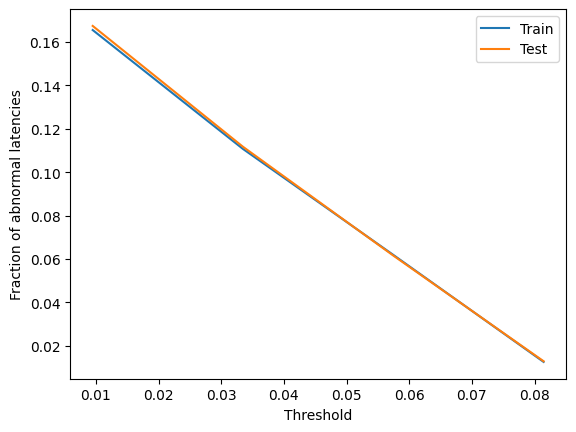

   Threshold  Train Fraction  Test Fraction
0   0.009487        0.165548       0.167446
1   0.033471        0.110739       0.111746
2   0.057456        0.061928       0.061611
3   0.081440        0.012603       0.012920


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


latency_mean = train_df['latency'].mean()
latency_std = train_df['latency'].std()
thresholds = []

for i in range(4):

# Define threshold for abnormal latency as three standard deviations away from the mean of TrainDF
  thresholds.append(latency_mean + i*latency_std)

# Define empty lists to store results
train_labels_list = []
train_fractions_list = []
test_labels_list = []
test_fractions_list = []

# Loop over threshold values
for threshold in thresholds:

    train_df['latency_label'] = np.where(train_df['latency'] > threshold, 1, 0)
    test_df['latency_label'] = np.where(test_df['latency'] > threshold, 1, 0)

    # Compute fraction of abnormal latencies
    train_fraction = train_df['latency_label'].value_counts()[1]/train_df.shape[0]
    test_fraction = test_df['latency_label'].value_counts()[1]/test_df.shape[0]
    #test_fraction = test_df['latency_label'].mean()

    # Append results to lists
    train_labels_list.append(train_df['latency_label'])
    train_fractions_list.append(train_fraction)
    test_labels_list.append(test_df['latency_label'])
    test_fractions_list.append(test_fraction)


# Plot results
plt.plot(thresholds, train_fractions_list, label='Train')
plt.plot(thresholds, test_fractions_list, label='Test')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Fraction of abnormal latencies')
plt.show()

# Create table of results
results = pd.DataFrame({'Threshold': thresholds, 'Train Fraction': train_fractions_list, 'Test Fraction': test_fractions_list})
print(results)


In [157]:
train_df['latency_label'].value_counts(),test_df['latency_label'].value_counts()

KeyError: ignored

### determine

In [164]:
latency_threshold = (latency_mean + 1*latency_std)

train_df['latency_label'] = np.where(train_df['latency'] > latency_threshold, 1, 0)
test_df['latency_label'] = np.where(test_df['latency'] > latency_threshold, 1, 0)


## backup and debugging

In [ ]:
print(train_dforiginal.shape, len(train_df))
print(test_dforiginal.shape, len(test_df))


(10000, 7) 10000
(10000, 7) 10000


In [ ]:
earliest_train = train_df.index.min()
latest_train = train_df.index.max()
earliest_test = test_df.index.min()
latest_test = test_df.index.max()

print("Earliest train timestamp:", earliest_train)
print("Latest train timestamp:", latest_train)
print("Earliest test timestamp:", earliest_test)
print("Latest test timestamp:", latest_test)


Earliest train timestamp: 2023-04-18 00:28:36.741168+00:00
Latest train timestamp: 2023-04-18 00:57:39.686390+00:00
Earliest test timestamp: 2023-04-21 00:07:40.949091+00:00
Latest test timestamp: 2023-04-21 01:07:49.241144+00:00


In [ ]:
# in case of error
train_df = train_dforiginal
test_df = test_dforiginal

print(train_df.head)
print(test_df.head)

## create keys and dummies

In [120]:
train_df.to_csv('trainfinal.csv', index=True)
test_df.to_csv('testfinal.csv', index=True)

In [165]:
# concatenate the dataframes
df_concat = pd.concat([test_df, train_df], axis=0)


# create keys for both dataframes
df_concat['key'] = df_concat.groupby(['latency_label', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app'], dropna=False).ngroup()

# get dummies for the 'key' column
df_concat=df_concat[['key']]
df_concat = pd.get_dummies(df_concat, columns=['key'])


# split back into original dataframes
test_df = df_concat.iloc[:len(test_df), :]
train_df = df_concat.iloc[len(test_df):, :]

In [166]:
print(train_df.shape)
print(test_df.shape)
print(test_df.head())

(234807, 540)
(195606, 540)
                                  key_0  key_1  key_2  key_3  key_4  key_5  \
timestamp                                                                    
2023-04-21 13:06:18.757041+00:00      0      0      0      0      0      0   
2023-04-21 13:06:23.974268+00:00      0      0      0      0      0      0   
2023-04-21 13:06:24.258780+00:00      0      0      0      0      0      0   
2023-04-21 13:06:24.379785+00:00      0      0      0      0      0      0   
2023-04-21 13:06:24.383645+00:00      0      0      0      0      0      0   

                                  key_6  key_7  key_8  key_9  ...  key_530  \
timestamp                                                     ...            
2023-04-21 13:06:18.757041+00:00      0      0      0      0  ...        0   
2023-04-21 13:06:23.974268+00:00      0      0      0      0  ...        0   
2023-04-21 13:06:24.258780+00:00      0      0      0      0  ...        0   
2023-04-21 13:06:24.379785+00:00   

# AUTOENCODER

## gpu test

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.experimental.list_physical_devices('GPU')

Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## timeseries

In [123]:


num_steps = 20
features = train_df.shape[1]

train_batches = (train_df.shape[0] // num_steps) * num_steps
train_data = train_df.iloc[:train_batches]

features = train_df.shape[1]
x_train_shaped = np.reshape(train_data.to_numpy(), newshape=(-1, num_steps, features))


In [147]:
test_batches = (test_df.shape[0] // num_steps) * num_steps
test_data = test_df.iloc[:test_batches]

features = test_df.shape[1]
x_test_shaped = np.reshape(test_data.to_numpy(), newshape=(-1, num_steps, features))


In [127]:
x_train_shaped.shape, x_test_shaped.shape

((41714, 20, 615), (20174, 20, 615))

## define model

In [128]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense


# Define the model 
model = Sequential()

# Encoder
model.add(LSTM(128, activation='tanh', input_shape=(x_train_shaped.shape[1],x_train_shaped.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(RepeatVector(x_train_shaped.shape[1]))

# Decoder
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(x_train_shaped.shape[2])))

model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 20, 128)           380928    
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 20, 64)           0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 20, 64)            33024     
                                                                 
 lstm_19 (LSTM)              (None, 20, 128)           98816     
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 615)          79335     
 tributed)                                            

In [129]:
model.layers[0].input_shape


(None, 20, 615)

### fit

In [170]:
import matplotlib.pyplot as plt

epochs = 250
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.

history = model.fit(x_train_shaped,x_train_shaped, epochs=epochs, validation_split=0.2, callbacks=[model_checkpoint_callback])

# Plot training and validation loss over epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Epoch 1/250
 304/1043 [=======>......................] - ETA: 7s - loss: 2.5502e-04 - accuracy: 0.8751

KeyboardInterrupt: ignored

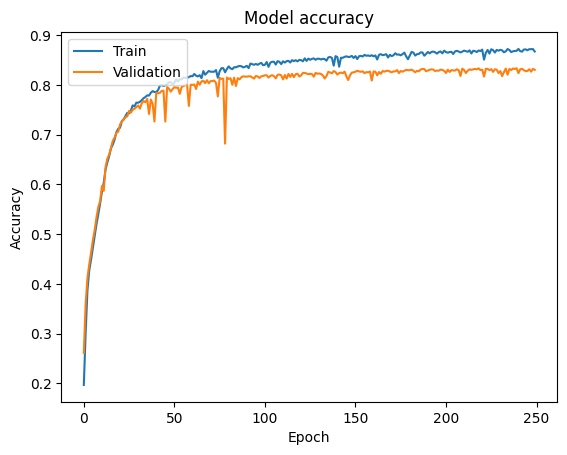

In [131]:
import matplotlib.pyplot as plt

# load the best weights
model.load_weights(checkpoint_filepath)

# Get the value of the validation accuracy at each epoch
val_acc = history.history['val_accuracy']

# Get the epoch with the highest validation accuracy
best_epoch = np.argmax(val_acc)

# plot accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


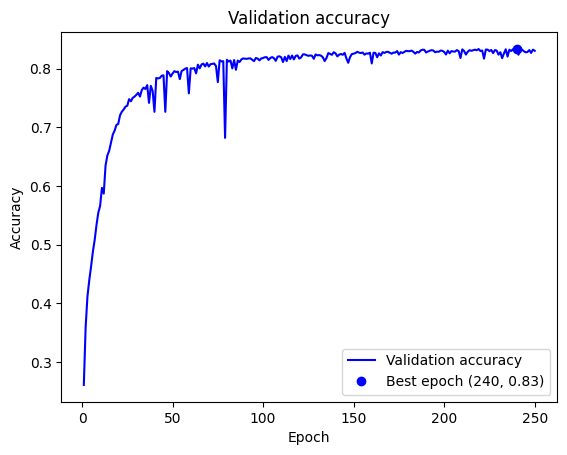

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already defined val_acc and best_epoch as shown in the previous code snippet

# Plot validation accuracy vs. epoch
epochs = range(1, len(val_acc) + 1)
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

# Add a point at the best epoch
best_val_acc = val_acc[best_epoch]
plt.plot(best_epoch + 1, best_val_acc, 'bo', label=f'Best epoch ({best_epoch + 1}, {best_val_acc:.2f})')

# Add labels and legend
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### predict train

In [133]:
X_pred = model.predict(x_train_shaped)
X_pred_test = model.predict(x_test_shaped)
model.save('model{}.h5'.format(timesteps))

1304/1304 [==============================] - 7s 4ms/step


### Predict test

631/631 [==============================] - 3s 4ms/step


### save model

In [135]:
# save the model


# Classify

In [136]:
from sklearn.metrics import mean_squared_error

# Iterate over each sequence in X_train

def calc_mse(X,X_predict):
  mse_list = []
  for i in range(X.shape[0]):
      # Get the current sequence
      sequence = X[i]

      # Calculate the mean squared error for the sequence
      mse = mean_squared_error(sequence, X_predict[i])
      mse_list.append(mse)
  return mse_list

In [148]:
mse_train = calc_mse(x_train_shaped, X_pred)
mse_test = calc_mse(x_test_shaped, X_pred_test)


# approx the best threshold

In [188]:
import pandas as pd
import numpy as np
def threshold_loop(mse_train,mse_test):
  mean_error = np.mean(mse_train)
  std_error = np.std(mse_train)

  def classify(mse_list, threshold):
    classified = []
    for i in range(len(mse_list)):
      classified.append(0 if mse_list[i] < threshold else 1)
    return classified

  # Set threshold as a certain number of standard deviations from the mean
  std_deviations = [0.1, 0.5, 1, 1.1, 1.25, 1.3, 1.4, 1.5, 1.75, 2,2.5, 3]
  results = []

  for num_std in std_deviations:
    threshold = mean_error + num_std * std_error
    train_classified = classify(mse_train, threshold)
    test_classified = classify(mse_test, threshold)

    TP = test_classified.count(1)
    FP = train_classified.count(1)
    TN = train_classified.count(0)
    FN = test_classified.count(0)
    try:
      accuracy = (TP + TN) / (TP + FP + TN + FN)
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      f1_score = 2 * (precision * recall) / (precision + recall)
      specificity = TN / (TN + FP)
      fpr = FP / (TN + FP)
    except Exception as err:
      print(err)
      continue
    results.append({
        'SDs': num_std,
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score,
        'Specificity': specificity,
        'FPR': fpr
    })

  # Create table of results
  results_df = pd.DataFrame(results)
  print("********* RESULTS WITH SD "+str(num_std)+"********")
  print(results_df)
  print("***********")
  return results_df


In [143]:
results_df = threshold_loop(mse_train,mse_test)
results_df

NameError: ignored

In [111]:
results_df.style.to_latex()

TypeError: ignored

# AUTOENCODER AS FUNCTION

In [191]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense

window_results_df = pd.DataFrame(columns=['seq_len', 'best_acc'])

def autoencode(seq_len, epochs):
  
  print('TRAINDF SHAPE: ' + str(train_df.shape))
  '''preprosses'''
  def shape(df):
    features = train_df.shape[1]
    batches = (df.shape[0] // seq_len) * seq_len
    data = df.iloc[:batches]

    df_shaped = np.reshape(data.to_numpy(), newshape=(-1, seq_len, features))

    return df_shaped


  x_train_shaped = shape(train_df.copy())
  x_test_shaped = shape(test_df.copy())
  print("X_TRAIN_SHAPED SHAPE: " + str(x_train_shaped.shape))
  '''define model'''
  model = Sequential()

  # Encoder
  model.add(LSTM(128, activation='tanh', input_shape=(x_train_shaped.shape[1],x_train_shaped.shape[2]), return_sequences=True))
  model.add(LSTM(64, activation='tanh', return_sequences=False))
  model.add(RepeatVector(x_train_shaped.shape[1]))

  # Decoder
  model.add(LSTM(64, activation='tanh', return_sequences=True))
  model.add(LSTM(128, activation='tanh', return_sequences=True))
  model.add(TimeDistributed(Dense(x_train_shaped.shape[2])))

  model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
  print("******* SUMMARY WITH SEQ_LEN: " + str(seq_len))
  print(model.summary())

  '''fit'''

  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


  history = model.fit(x_train_shaped,x_train_shaped, epochs=epochs, validation_split=0.2, callbacks=[model_checkpoint_callback])

  # Plot training and validation loss over epochs
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss at seq len {}'.format(seq_len))
  plt.legend()
  plt.show()

  ''''pred & results '''

  print("****** PREDICTING *******")
  X_pred = model.predict(x_train_shaped)
  X_pred_test = model.predict(x_test_shaped)
  #model.save('model{}.h5'.format(seq_len))

  print("****** MSE CALC *******")
  mse_train = calc_mse(x_train_shaped, X_pred)
  mse_test = calc_mse(x_test_shaped, X_pred_test)

  print("****** {} THRESHOLD LOOPING *******".format(seq_len))
  current_results_df = threshold_loop(mse_train,mse_test)


  best_row = results_df.iloc[results_df['Accuracy'].idxmax()]
  window_results_df.loc[seq_len] = best_row
  
  

In [193]:
 best_row = results_df.iloc[results_df['Accuracy'].idxmax()]


SDs            2.000000
Threshold      0.000770
Accuracy       0.690118
Precision      0.594821
Recall         0.154853
F1-score       0.245733
Specificity    0.948986
FPR            0.051014
Name: 13, dtype: float64

TRAINDF SHAPE: (234807, 540)
X_TRAIN_SHAPED SHAPE: (23480, 10, 540)
******* SUMMARY WITH SEQ_LEN: 10
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 10, 128)           342528    
                                                                 
 lstm_61 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_15 (RepeatVec  (None, 10, 64)           0         
 tor)                                                            
                                                                 
 lstm_62 (LSTM)              (None, 10, 64)            33024     
                                                                 
 lstm_63 (LSTM)              (None, 10, 128)           98816     
                                                                 
 time_distributed_

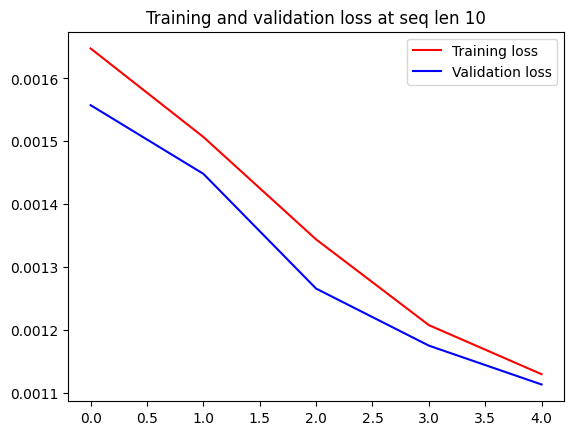

****** PREDICTING *******
612/612 [==============================] - 2s 4ms/step
****** MSE CALC *******


In [ ]:
window_results_df = pd.DataFrame(columns=['seq_len', 'best_row'])
epochs = 5
for seq_len in [10,20]:
  autoencode(seq_len, epochs)
window_results_df

# Legacy

In [84]:
TP = test_classified.count(1)
FP = train_classified.count(1)
TN = train_classified.count(0)
FN = test_classified.count(0)

NameError: ignored

In [ ]:
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
fpr = FP / (TN + FP)


In [ ]:
confusion_matrix = pd.DataFrame(
    {
        '': ['Actual Positive', 'Actual Negative'],
        'Predicted Positive': [TP, FP],
        'Predicted Negative': [FN, TN]
    }
)

# Convert the dataframe to a LaTeX table
confusion_matrix_latex = confusion_matrix.style.to_latex()

# Print the table and the metrics
print(confusion_matrix_latex)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')

\begin{tabular}{llrr}
 &  & Predicted Positive & Predicted Negative \\
0 & Actual Positive & 853 & 147 \\
1 & Actual Negative & 345 & 655 \\
\end{tabular}

Accuracy: 0.75
Precision: 0.71
Recall: 0.85
F1-score: 0.78
